# Power Analysis for Multiple Hypothesis Testing
When conducting statistical tests, there are some convoluted relationships between significance level, power, sample size, and so on. In this notebook we will go through how P-values are affected under different circumstances.  
In the end, we will implement *Bonferroni Correction* and *Benjamin-Hochberg Procedure* for correcting P-values in multiple hypothesis testings.

## Permutation/ Randomization Tests
Usually, hypothesis tests rely on central limit theory when calculating the rejection region for the test.   However, we don’t have to rely on these approximations and can in fact go about making decisions nonparametrically using permutation and randomization tests. Here, we’ll tackle implementation of randomization tests.

First we write a function which takes two samples (y11, . . . , y1n1 ) and (y21, . . . y2n2 ), the number of permutations B, and the alternative as input;  
outputs a p-value for the difference of the means of the two samples, and the difference of standard deviation of the two samples.  

In [1]:
import random
import seaborn as sns
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
def permutation(y_1, y_2, B, alter, target):
    if target == 'mean':
        t_orig = np.mean(y_1) - np.mean(y_2)
    else:
        t_orig = np.std(y_1) - np.std(y_2)
    y = y_1 + y_2
    y_sample_len = int(len(y) / 2)
    #  perform permutation B times
    greater_count = 0
    less_count = 0
    equal_count = 0
    y_all = np.random.choice(y, size=len(y), replace=False, p=None)
    for _ in range(B):
        y_1_sample = y_all[:y_sample_len]
        y_2_sample = y_all[y_sample_len:]
        if target == 'mean':
            t_star = np.mean(y_1_sample) - np.mean(y_2_sample)
        else:
            t_star = np.std(y_1_sample) - np.std(y_2_sample)
        if  t_star >= abs(t_orig):
            equal_count += 1
        if t_star > t_orig:
            greater_count += 1
        elif t_star < t_orig:
            less_count += 1
    if alter == 'not.equal':
        return equal_count / B

    elif alter == 'less.than':
        return less_count / B

    else:
        return greater_count / B


(b) Simulate two samples as normal random variables with means μ1 and μ2 and variances σ12,σ2, respectively, where the parameters are set as the following:  
 i. μ1 =μ2 + δ for μ2 = 0 and δ = 0, .5, 1, 2 when σ 12 = σ2 = 1.   
 ii. σ12 = σ2 + δ for σ2 = 1, and δ = 0, .5, 1, 2 when μ1 = μ2 = 0  

In [15]:
# mu_1, sigma_1 = 0, 1  # mean and standard deviation for y_1
mu_2, sigma_2 = 0, 1  # mean and standard deviation for y_2
delta = [0, 0.5, 1, 2]
p_mean = []
p_std = []
B_s = []
delta_s = []
for d in delta:
    print(f'               Delta = {d}') 
    y_1 = np.random.normal(mu_2 + d, sigma_2 + d, 10000)
    y_2 = np.random.normal(mu_2, sigma_2, 10000)
    for B in [10, 100, 1000]:
        print(f'=====================B = {B}=======================')
        pmean = permutation(y_1, y_2, B, 'not.equal', 'mean')
        pstd = permutation(y_1, y_2, B, 'not.equal', 'std')
        print(f'p mean: {pmean}, p std: {pstd}')
        p_mean.append(pmean)
        p_std.append(pstd)
        B_s.append(B)
        delta_s.append(d)

               Delta = 0
=====================B = 10=======================
p mean: 1.0, p std: 0.0
=====================B = 100=======================
p mean: 0.0, p std: 1.0
=====================B = 1000=======================
p mean: 0.0, p std: 0.0
               Delta = 0.5
=====================B = 10=======================
p mean: 0.0, p std: 0.0
=====================B = 100=======================
p mean: 0.0, p std: 0.0
=====================B = 1000=======================
p mean: 0.0, p std: 0.0
               Delta = 1
=====================B = 10=======================
p mean: 0.0, p std: 0.0
=====================B = 100=======================
p mean: 0.0, p std: 0.0
=====================B = 1000=======================
p mean: 0.0, p std: 0.0
               Delta = 2
=====================B = 10=======================
p mean: 0.0, p std: 0.0
=====================B = 100=======================
p mean: 0.0, p std: 0.0
=====================B = 1000=======================
p mean: 0.

In [16]:
p_values = pd.DataFrame({'B' : B_s,
              'delta': delta_s,
              'p_mean': p_mean,
              'p_std': p_std,
})
p_values

,B,delta,p_mean,p_std
0,10,0.0,1.0,0.0
1,100,0.0,0.0,1.0
2,1000,0.0,0.0,0.0
3,10,0.5,0.0,0.0
4,100,0.5,0.0,0.0
5,1000,0.5,0.0,0.0
6,10,1.0,0.0,0.0
7,100,1.0,0.0,0.0
8,1000,1.0,0.0,0.0
9,10,2.0,0.0,0.0


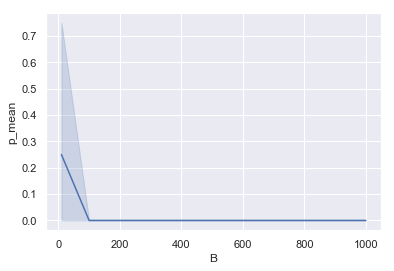

In [17]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.lineplot(x="B", y="p_mean", data=p_values)

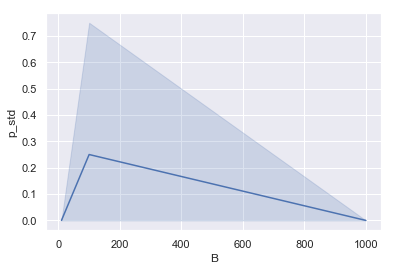

In [18]:
ax = sns.lineplot(x="B", y="p_std", data=p_values)

* We can see that with permutation, increasing the number of times of permutation, the p-value goes all the way down, as long as we have a non-trivial effect size.

## Sample Size Calculator
If we are testing differences of means or proportions, it is possible to calculate the power of the test that we run when comparing two conditions. 
In general, the power of a test depends on the following components:  
• effect size δ: the difference in mean or proportion   
• sample size of each group n1 and n2  
• significance level α  

Hence, we can define sample size calculators, depends on whether we're testing the proportion or not, as below:

In [4]:
def samplesize(alpha, effect_size, k, var, power, alt):
    if alt == 'not.equal':
        z_alpha = stats.norm.ppf(alpha / 2)
    else:
        z_alpha = stats.norm.ppf(alpha)
    z_beta = stats.norm.ppf(power)
    n2 = ((1 / k) + 1) * var * ((z_alpha - z_beta) ** 2) / (effect_size ** 2) 
    n1 = k * n2
    return round(n1), round(n2)

In [5]:
def samplesize_pro(alpha, effect_size, k, power, pi_1, pi_2, alt):
    if alt == 'not.equal':
        z_alpha = stats.norm.ppf(alpha / 2)
    else:
        z_alpha = stats.norm.ppf(alpha)
    z_beta = stats.norm.ppf(power)
    var_p1 = pi_1 * (1 - pi_1)
    var_p2 = pi_2 * (1 - pi_2)
    n2 = ((var_p1 / k) + var_p2) * ((z_alpha - z_beta) ** 2) / (effect_size ** 2) 
    n1 = k * n2
    return round(n1, 1), round(n2, 1)

For example, the sample size needed in a comparison of means with α = 0.05 when we want to detect an effect size of 0.10 with a power of 0.80(assuming variance=1), is simply:


In [6]:
print(samplesize(0.05, 0.1, 1, 1, 0.8, 'not.equal'))

(1570.0, 1570.0)


We can also write a function to calculate the power for each of the above tests which depend on α, n2, k, σ2 and the desired effect size δ

In [8]:
def power_cal(alpha, n2, k, var, effect_size, alt, pi_1):
    if alt == 'not.equal':
        z_alpha = stats.norm.ppf(alpha / 2)
    else:
        z_alpha = stats.norm.ppf(alpha)
    n1 = k * n2
    pi_2 = pi_1 + effect_size
    var_p1 = pi_1 * (1 - pi_1)
    var_p2 = pi_2 * (1 - pi_2)
    threshold = z_alpha - (effect_size / np.sqrt(var_p1 / n1 +\
                          var_p2 / n2))
    return stats.norm.cdf(threshold)

We can thus plot the power of the comparison of equality of proportions   
when δ ranges from 0.10 to 0.90 in increments of 0.10, n2 =30, k=1, π1 =0.1, and π2 = π1 + δ.

In [9]:
powers = []
e_size = []
for effect_size in np.arange(0.1, 1, 0.1):
    powers.append(power_cal(0.05, 30, 1, 1, effect_size, 'not.equal', 0.1))
    e_size.append(effect_size)

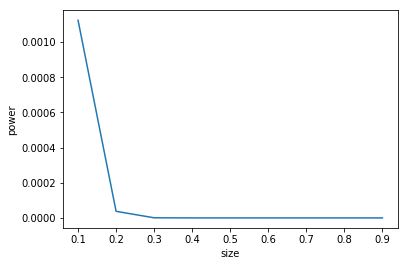

In [10]:
power_df = pd.DataFrame({'power': powers,
                        'size': e_size})
ax = sns.lineplot(x="size", y="power", data=power_df)

* We can clearly see that when effect size increases, power decreases.

# Bonferroni Correction and Benjamin-Hochberg Procedure
We will implement and calculate the power of the test for multiple comparisons. The function/calculators here could be used on experiment platforms! 

In [11]:
m = 1000
alpha = 0.05

def corrections(alpha, m, method='bon', p_vals=None):
    p_adjusted = []
    if method != 'bon':
        for i in range(m):
            p_adjusted.append(i * alpha / m)

    else:
        p_adjusted = [alpha / m for _ in range(m)]
    return p_adjusted

In [12]:
def bh_power_cal(m, n2, k, var, effect_size, alpha=0.05):
    p_adjusted = corrections(alpha, m, 'bh')
    powers = []
    for p in p_adjusted:
        power = power_cal(p, n2, k, var, effect_size, 'not.equal', 0.1)
        powers.append(power)
    return powers

Suppose now we have 100 independent tests of means, we set α=0.05 and have n2 = 30, σ2 = 1 and k=1.     
Furthermore suppose that we would like to detect an effect size of δ = 0.25 in each test.   

In [13]:
bh_powers = bh_power_cal(100, 30, 1, 1, 0.25, alpha=0.05)

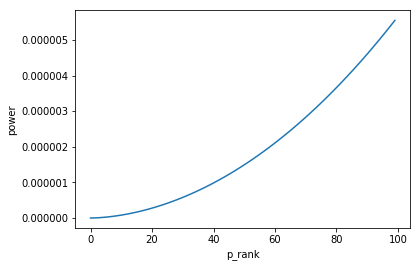

In [14]:
power_df = pd.DataFrame({'power': bh_powers,
                        'p_rank': range(100)})
ax = sns.lineplot(x="p_rank", y="power", data=power_df)

* We can see clearly that when the rank of p goes up(toward no-correction), the power of the test goes up as well.